13520133 - Jevant Jedidia

13520160 - Willy Wilsen 

# Tugas Prapraktikum

Tugas Prapraktikum dikerjakan dengan _dataset_ [Rain in Australia](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package/download?datasetVersionNumber=2). Tanpa meninjau waktu (`date`), prediksi status hujan pada keesokan harinya (`RainTomorrow`). Berikan nilai `1` jika diprediksi hujan pada keesokan harinya, `0` jika tidak.

<br>
Tugas dikerjakan secara berkelompok. Setiap kelompok terdiri atas 2 (dua) mahasiswa. Kumpulkan paling lambat pada Minggu, 16 April 2023, pukul 23:59 WIB melalui Edunex.

# 0. Persiapan Data and Pustaka

In [1]:
# Letakkan pustaka di sini.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil, floor
from sklearn import datasets, metrics
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier, StackingClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [2]:
# Baca data di sini.
data = pd.read_csv('weatherAUS.csv')
data.drop(["Date"], axis = 1, inplace = True)
data.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


# I. Pemahaman Data
Tujuan dari bagian ini adalah peserta dapat memahami kualitas dari data yang diberikan. Hal yang diliputi adalah sebagai berikut:
1. Ukuran data
2. Statistik dari tiap fitur
3. Pencilan (_outlier_)
4. Korelasi
5. Distribusi 

## I.1 
Carilah:
1. Ukuran dari data (instansi dan fitur)
2. Tipe dari setiap fitur 
3. Banyak nilai unik dari fitur yang bertipe kategorikal
4. Nilai minimum, maksimum, rata-rata, median, dan standar deviasi dari fitur nonkategorikal

In [3]:
# I.1 Kode di sini.

# 1. Ukuran dari data (instansi dan fitur)
print("1. Ukuran dari data (instansi dan fitur)")
print("Jumlah instansi:", data.shape[0])
print("Jumlah fitur:", data.shape[1]-1)

# 2. Tipe dari setiap fitur
print("2. Tipe dari setiap fitur")
print(data.dtypes)

# 3. Banyak nilai unik dari fitur yang bertipe kategorikal
print("3. Banyak nilai unik dari fitur yang bertipe kategorikal")
data_unique = {}
for col in data:
    if data[col].dtype == "object":
        data_unique[col] = [data[col].nunique()]
data_unique = pd.DataFrame(data_unique)
print(data_unique)

# 4. Nilai minimum, maksimum, rata-rata, median, dan standar deviasi dari fitur nonkategorikal
print("4. Nilai minimum, maksimum, rata-rata, median, dan standar deviasi dari fitur nonkategorikal")
print("Minimum")
print(data.min(numeric_only=True))

print("\nMaximum")
print(data.max(numeric_only=True))

print("\nMedian")
print(data.median(numeric_only=True))

print("\nStandar Deviasi")
print(data.std(numeric_only=True))

1. Ukuran dari data (instansi dan fitur)
Jumlah instansi: 145460
Jumlah fitur: 21
2. Tipe dari setiap fitur
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object
3. Banyak nilai unik dari fitur yang bertipe kategorikal
   Location  WindGustDir  WindDir9am  WindDir3pm  RainToday  RainTomorrow
0        49           16          16          16          2             2
4. Nilai minimum, maksimum, rata-rata, median, dan standar deviasi dari fitur nonkategorikal
Minimum
MinTemp           -8.5

## I.2
Carilah:
1. Nilai hilang (_missing_) dari setiap fitur
2. Nilai pencilan (_outlier_) dari setiap fitur

In [4]:
# I.2 Kode di sini.

# 1. Nilai hilang (missing) dari setiap fitur
print("1. Nilai hilang (missing) dari setiap fitur")
print("Missing value count:")
print(data.isnull().sum())

# 2. Nilai pencilan (outlier) dari setiap fitur
print("2. Nilai pencilan (outlier) dari setiap fitur")
print("\nOutlier count:")
dataNum = data.select_dtypes(include=[np.number])
Q1 = dataNum.quantile(0.25)
Q3 = dataNum.quantile(0.75)
IQR = Q3 - Q1
((dataNum < (Q1 - 1.5 * IQR)) | (dataNum > (Q3 + 1.5 * IQR))).sum()

1. Nilai hilang (missing) dari setiap fitur
Missing value count:
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64
2. Nilai pencilan (outlier) dari setiap fitur

Outlier count:


MinTemp             54
MaxTemp            489
Rainfall         25578
Evaporation       1995
Sunshine             0
WindGustSpeed     3092
WindSpeed9am      1817
WindSpeed3pm      2523
Humidity9am       1425
Humidity3pm          0
Pressure9am       1191
Pressure3pm        919
Cloud9am             0
Cloud3pm             0
Temp9am            262
Temp3pm            764
dtype: int64

## I.3
Lakukan:
1. Pencarian korelasi antarfitur
2. Visualisasi distribusi setiap fitur (kategorikal dan kontinu)
3. Visualisasi distribusi setiap fitur per target (`RainTomorrow`)

1. Pencarian korelasi antarfitur
                MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  \
MinTemp        1.000000  0.736555  0.103938     0.466993  0.072586   
MaxTemp        0.736555  1.000000 -0.074992     0.587932  0.470156   
Rainfall       0.103938 -0.074992  1.000000    -0.064351 -0.227549   
Evaporation    0.466993  0.587932 -0.064351     1.000000  0.365602   
Sunshine       0.072586  0.470156 -0.227549     0.365602  1.000000   
WindGustSpeed  0.177415  0.067615  0.133659     0.203021 -0.034750   
WindSpeed9am   0.175064  0.014450  0.087338     0.193084  0.005499   
WindSpeed3pm   0.175173  0.050300  0.057887     0.129400  0.053834   
Humidity9am   -0.232899 -0.504110  0.224405    -0.504092 -0.490819   
Humidity3pm    0.006089 -0.508855  0.255755    -0.390243 -0.629130   
Pressure9am   -0.450970 -0.332061 -0.168154    -0.270362  0.041970   
Pressure3pm   -0.461292 -0.427167 -0.126534    -0.293581 -0.019719   
Cloud9am       0.078754 -0.289370  0.198528    -0.183793 

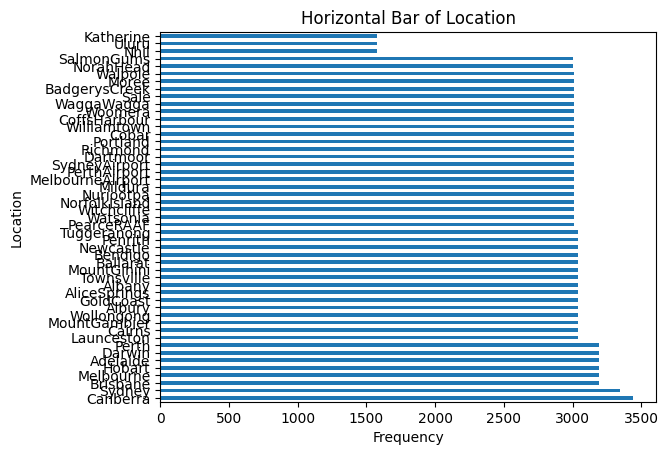

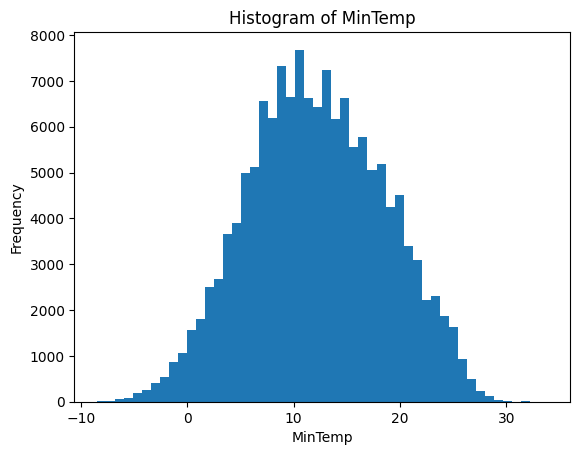

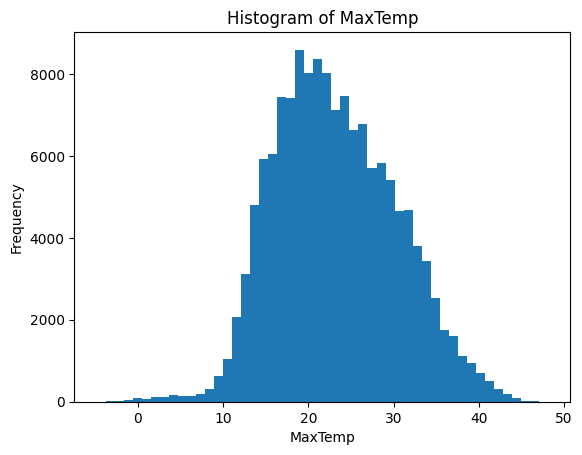

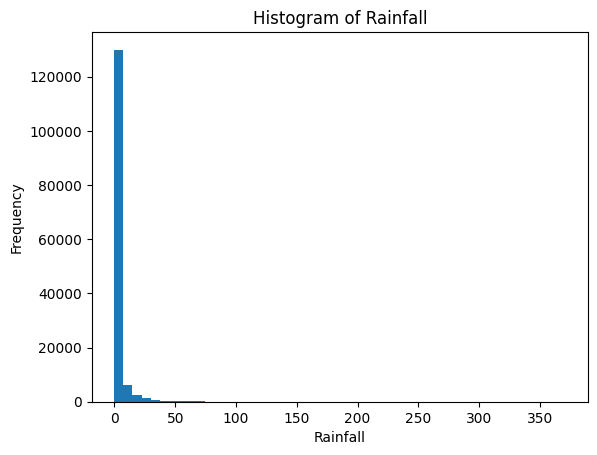

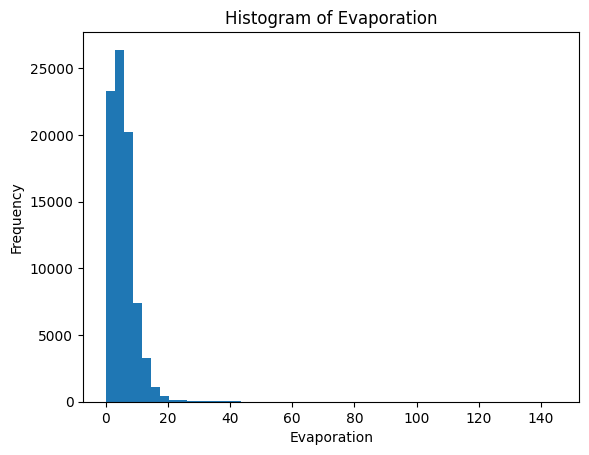

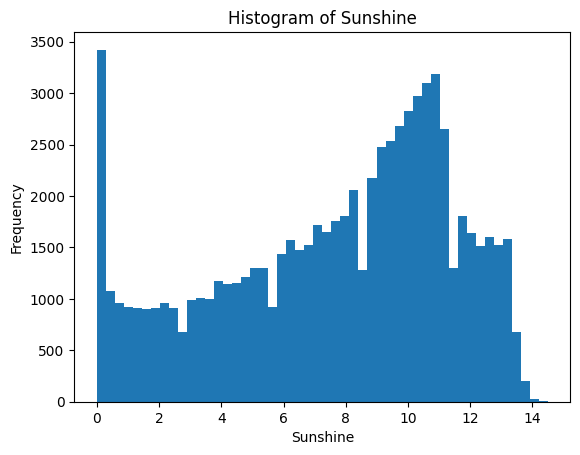

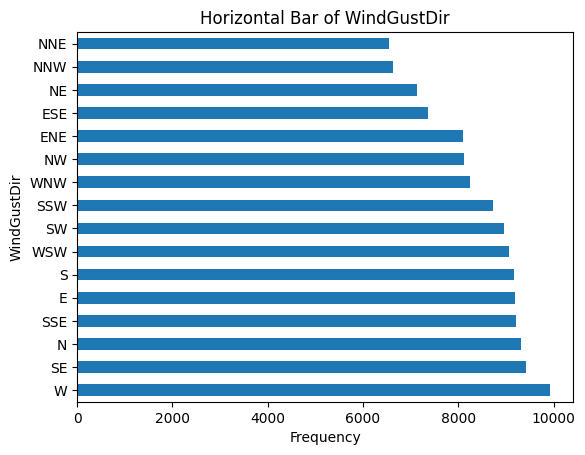

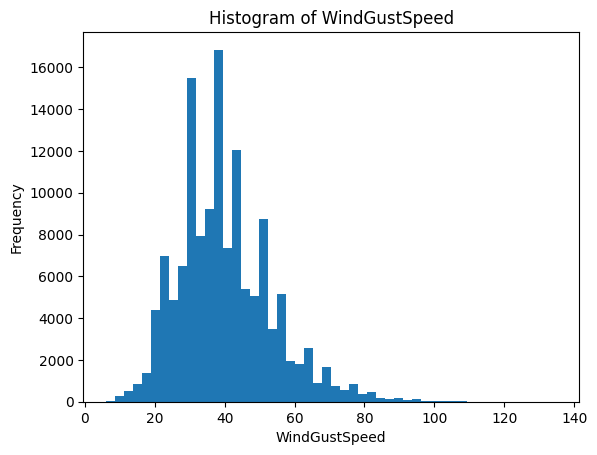

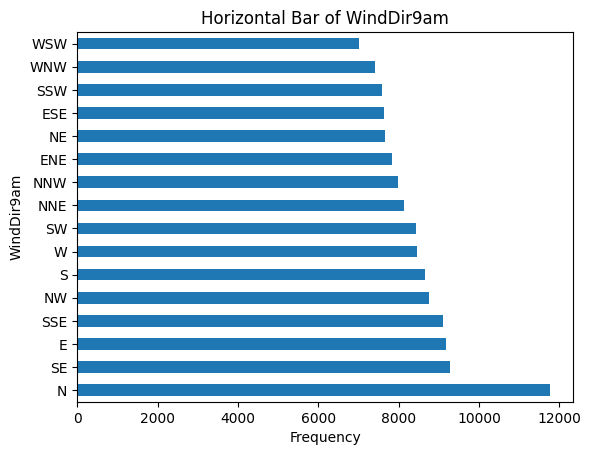

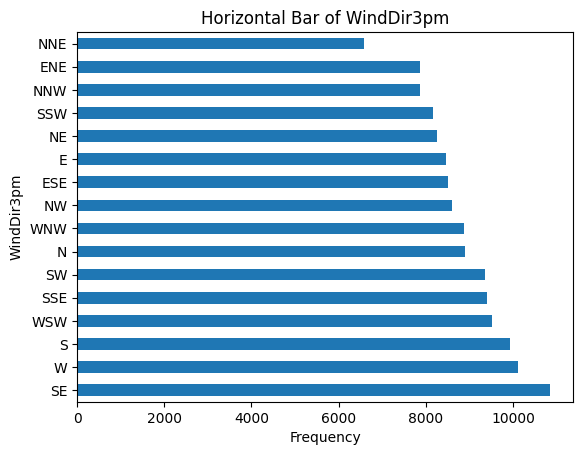

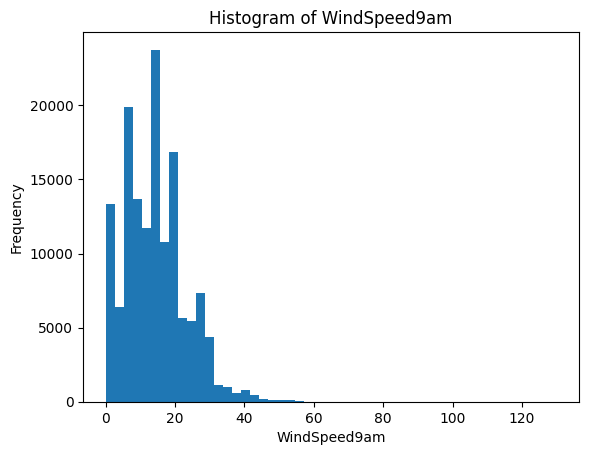

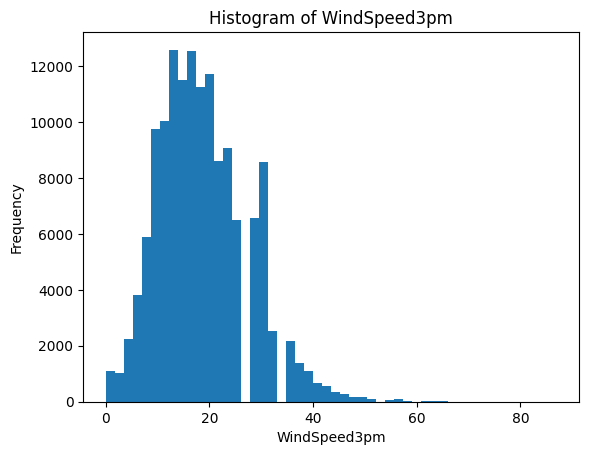

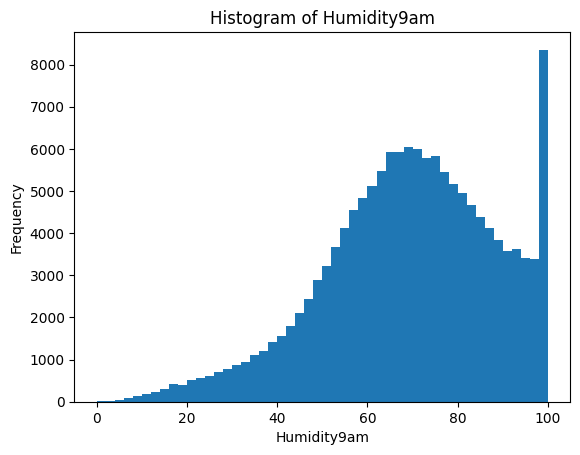

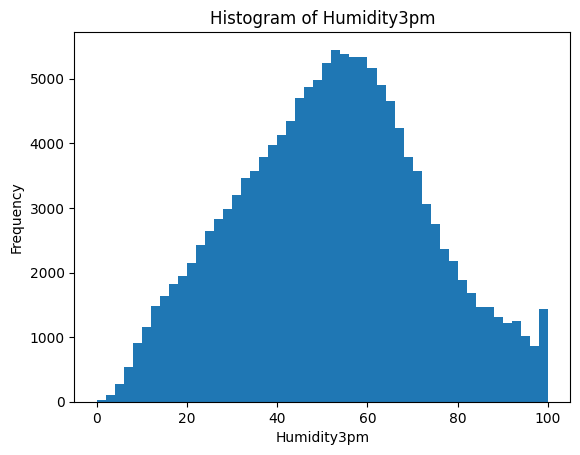

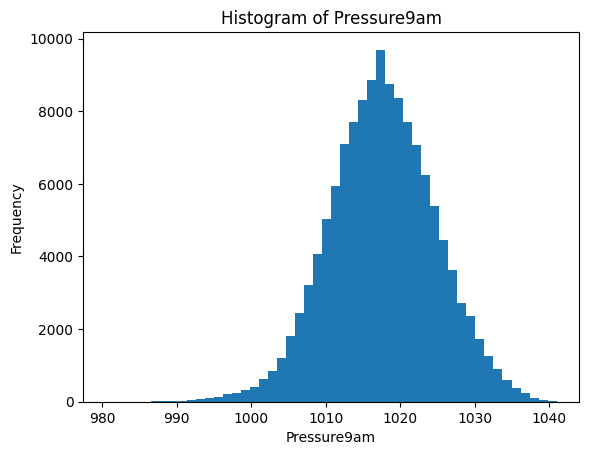

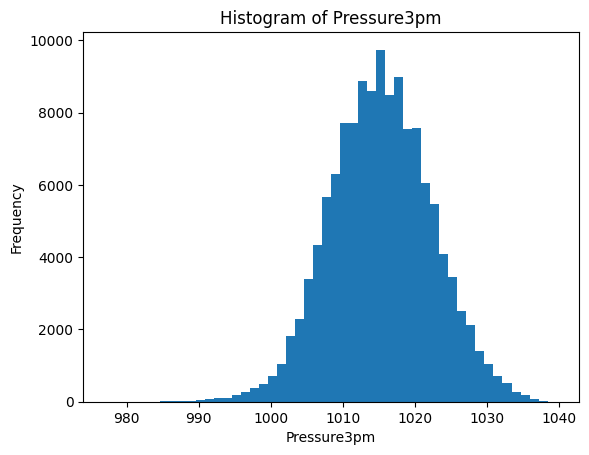

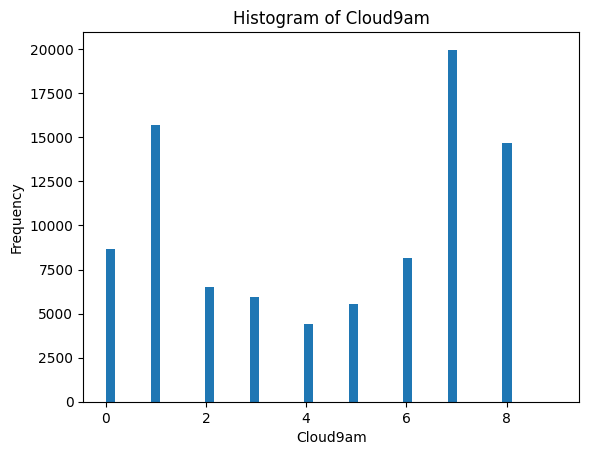

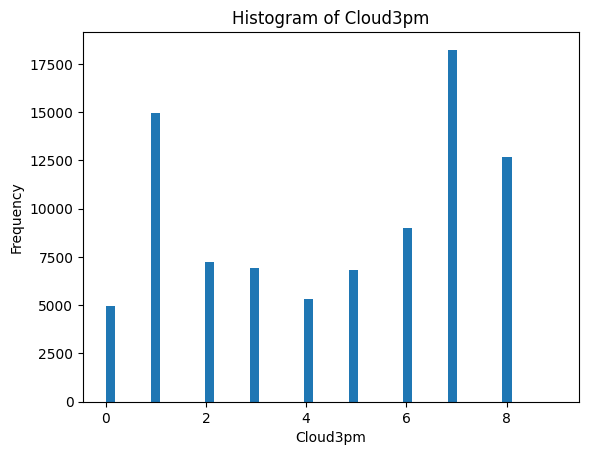

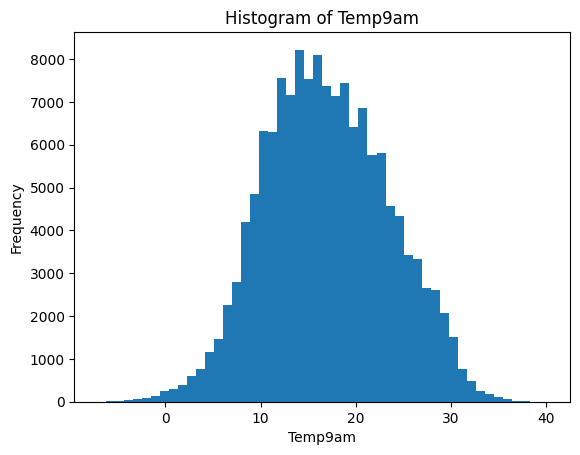

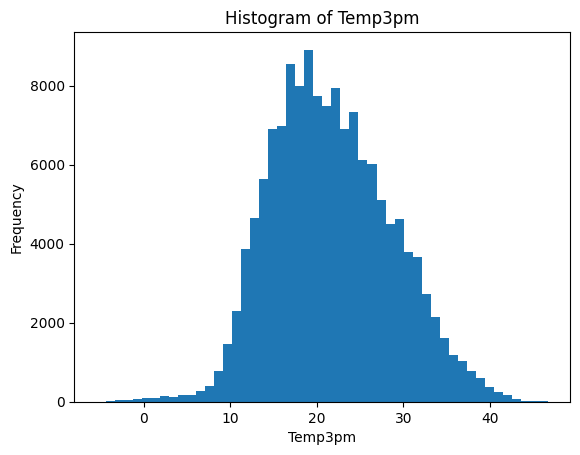

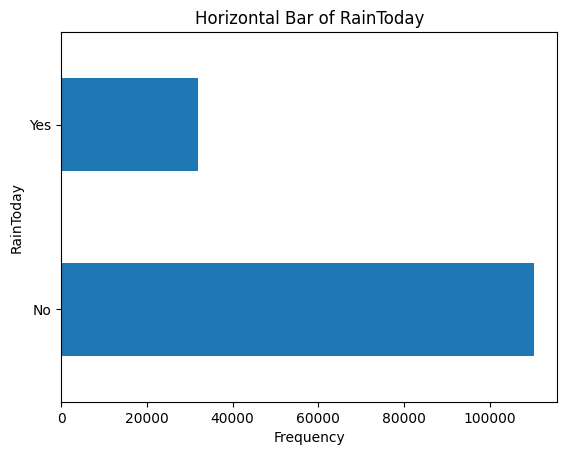

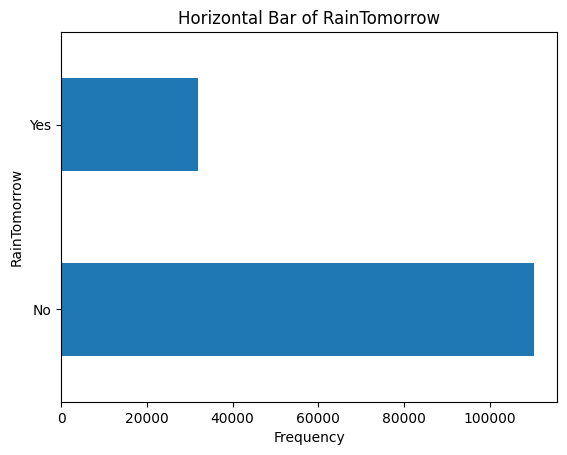

3. Visualisasi distribusi setiap fitur per target (RainTomorrow)


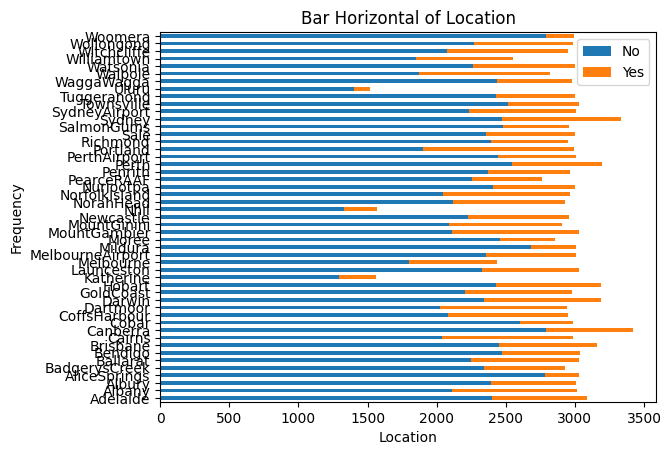

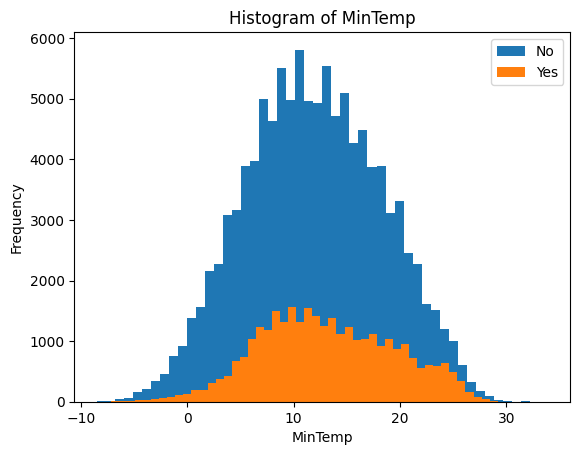

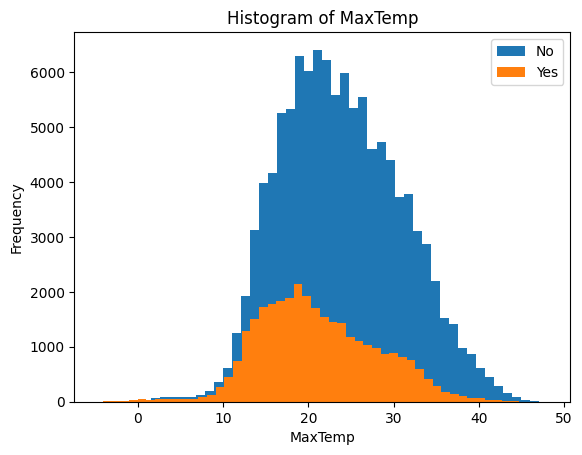

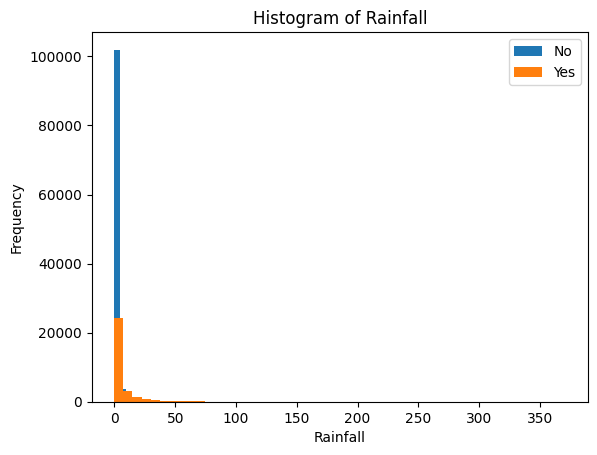

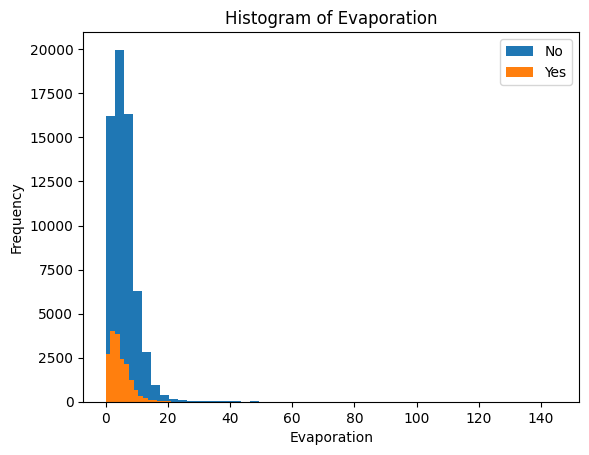

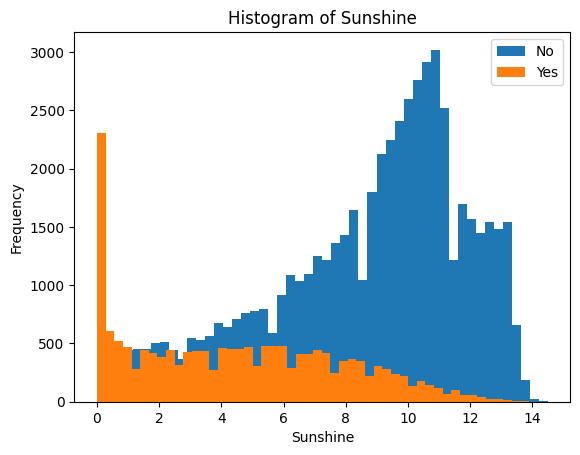

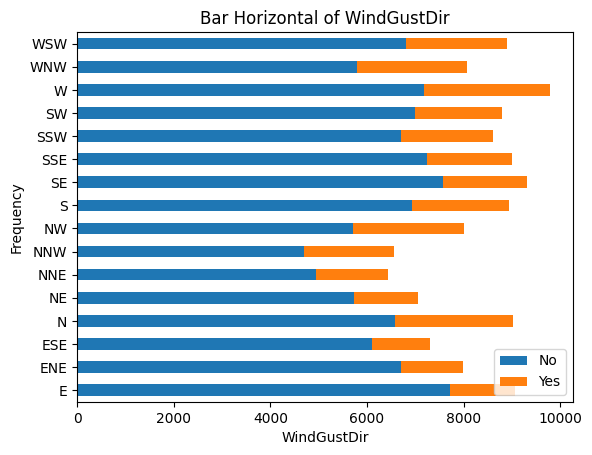

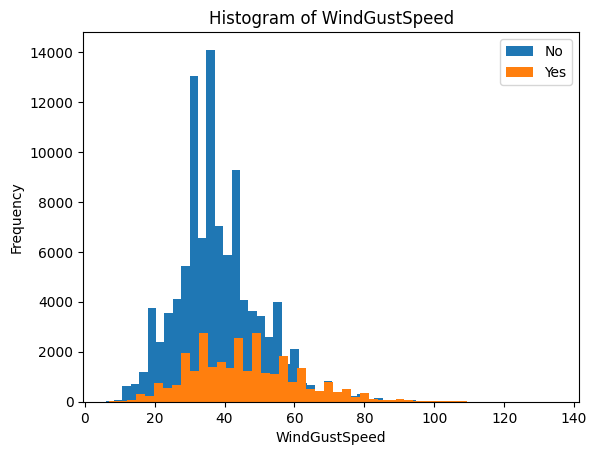

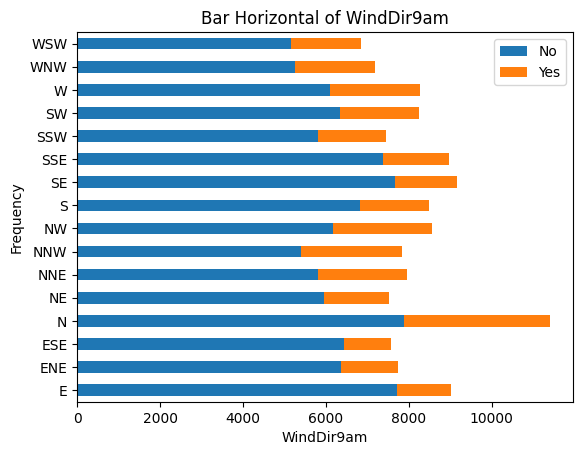

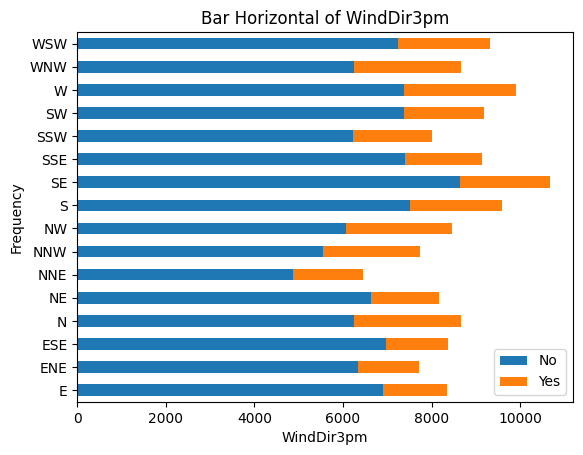

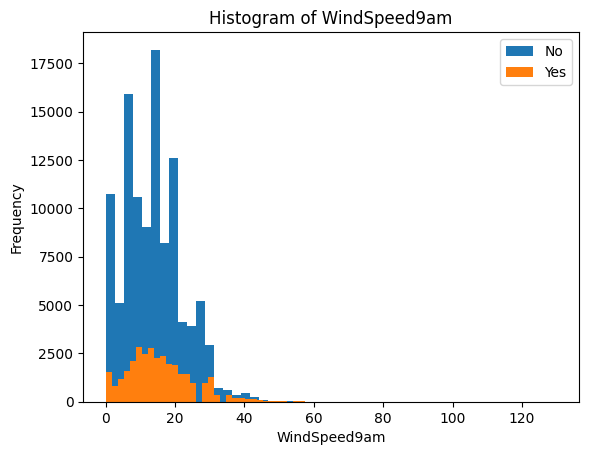

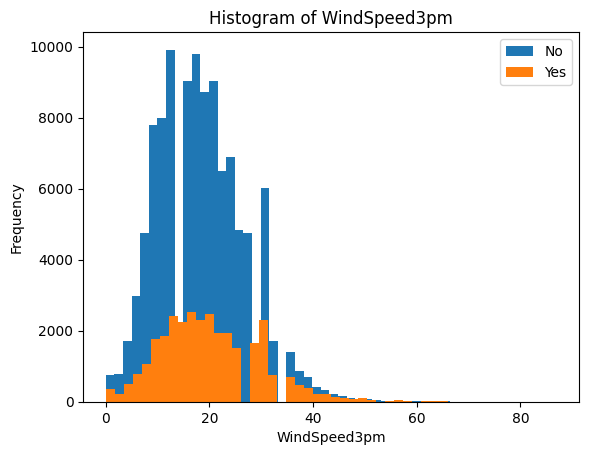

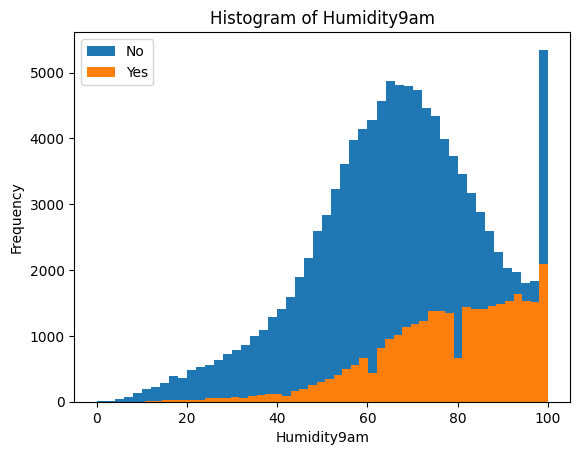

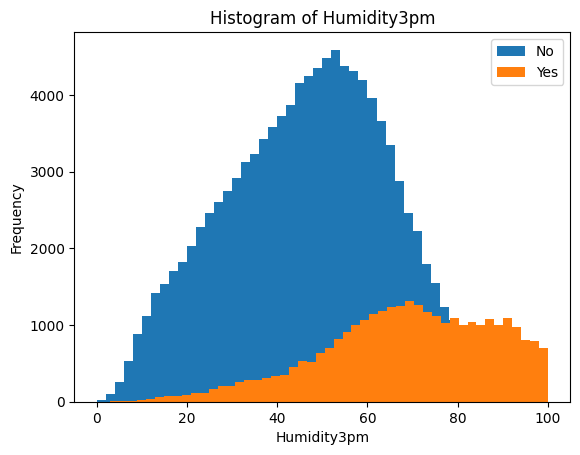

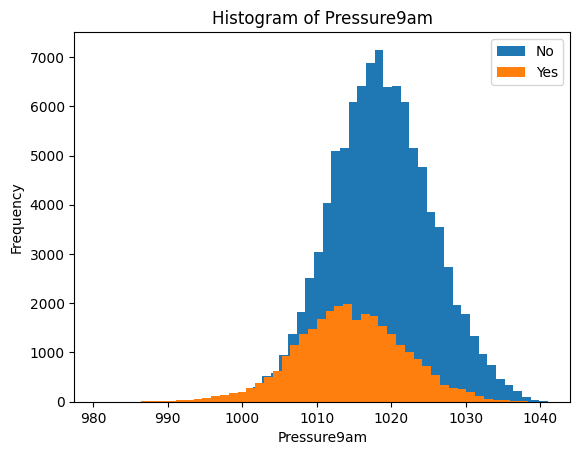

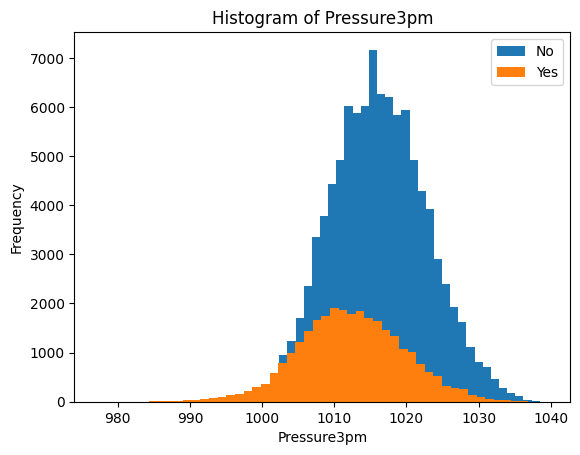

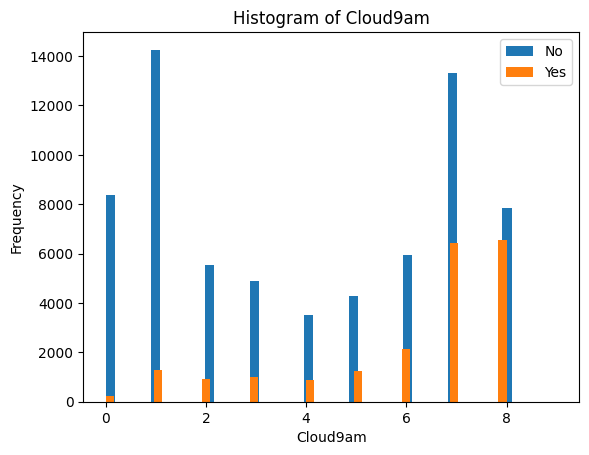

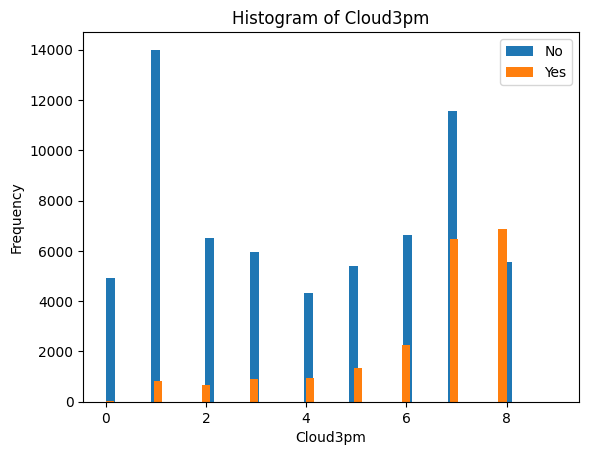

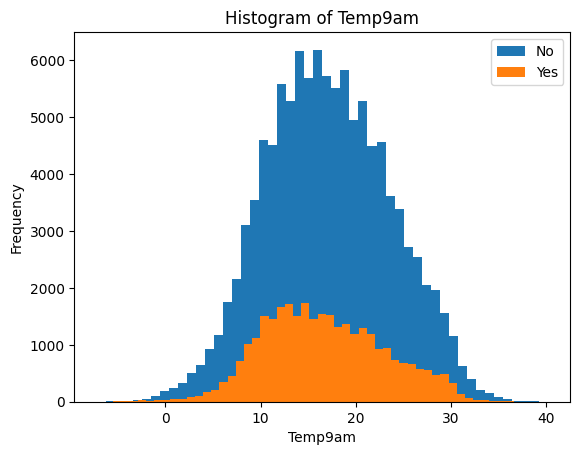

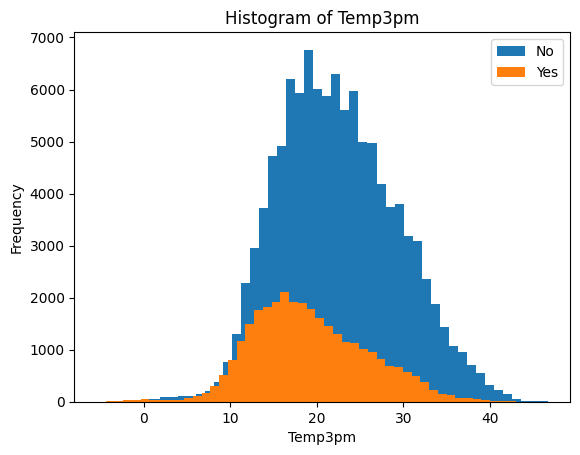

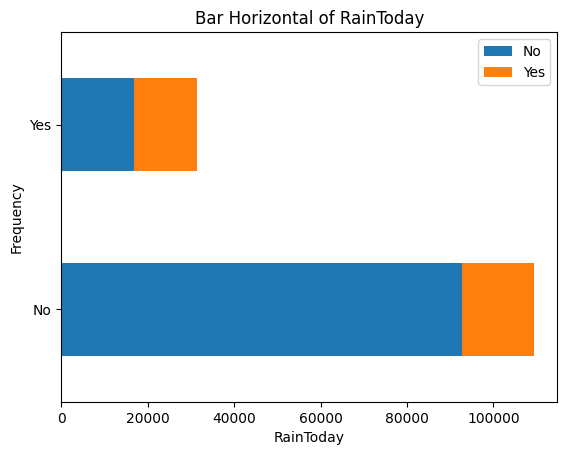

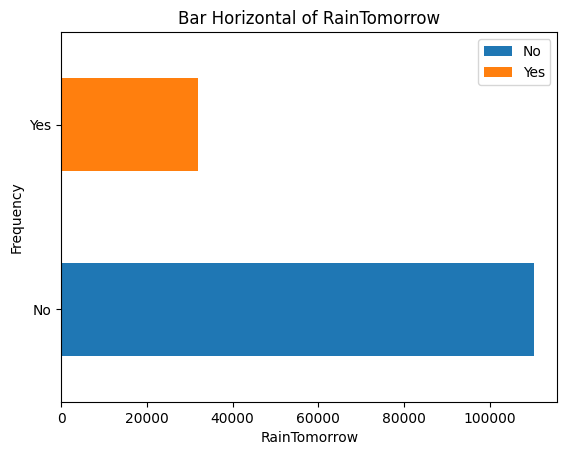

In [5]:
# I.3 Kode di sini.

# 1. Pencarian korelasi antarfitur
print("1. Pencarian korelasi antarfitur")
print(data.corr())

# 2. Visualisasi distribusi setiap fitur (kategorikal dan kontinu)
print("2. Visualisasi distribusi setiap fitur (kategorikal dan kontinu)")
for col in data:
    if data[col].dtype == "object": 
        data[col].value_counts(dropna = True).plot(kind='barh')
        plt.title('Horizontal Bar of ' + col)
        plt.xlabel('Frequency')
        plt.ylabel(col)
        plt.show()
    else:
        data[col].plot(kind='hist', bins=50)
        plt.title('Histogram of ' + col)
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()

# 3. Visualisasi distribusi setiap fitur per target (RainTomorrow)
print("3. Visualisasi distribusi setiap fitur per target (RainTomorrow)")
for col in data:
    if data[col].dtype == object:
        data.groupby(col)['RainTomorrow'].value_counts(dropna = True).unstack().plot(kind='barh', stacked=True)
        plt.title('Bar Horizontal of ' + col)
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()
    else:
        data.groupby('RainTomorrow')[col].plot(kind='hist', bins=50, stacked=True)
        plt.title('Histogram of ' + col)
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()

## I.4
Lakukanlah analisis lebih lanjut jika diperlukan, kemudian lakukan hal berikut:
1. Penambahan fitur jika memungkinkan
2. Pembuangan fitur yang menurut kalian tidak dibutuhkan
3. Penanganan nilai hilang
4. Transformasi data kategorikal menjadi numerikal (_encoding_)
5. _Scaling_ dengan `MinMaxScaler`

In [6]:
# I.4 Put your code here

# 1. Penambahan fitur jika memungkinkan
# Tidak perlu dilakukan penambahan fitur karena fitur pada dataset cukup untuk membuat model

# 2. Pembuangan fitur yang menurut kalian tidak dibutuhkan#
# Fitur yang tidak diperlukan adalah Location
DROP_COLUMN = ["Location"]
data.drop(DROP_COLUMN, axis = 1, inplace = True)

# 3. Penanganan nilai hilang
# Ubah missing value dengan most common value per column
for col in data.columns:
    common_value = data[col].value_counts(dropna = True).idxmax()
    data[col].fillna(common_value, inplace=True)

# 4. Transformasi data kategorikal menjadi numerikal (encoding)
encoder = LabelEncoder()
data['WindGustDir'] = encoder.fit_transform(data['WindGustDir'])
data['WindDir9am'] = encoder.fit_transform(data['WindDir9am'])
data['WindDir3pm'] = encoder.fit_transform(data['WindDir3pm'])
data['RainToday'] = encoder.fit_transform(data['RainToday'])
data['RainTomorrow'] = encoder.fit_transform(data['RainTomorrow'])

# 5. Scaling dengan MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
data = pd.DataFrame(scaled_data, columns = data.columns)
data.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,0.516509,0.523629,0.001617,0.027586,0.0,0.866667,0.294574,0.866667,0.933333,0.153846,...,0.71,0.22,0.449587,0.4800,0.888889,0.777778,0.508439,0.522073,0.0,0.0
1,0.375000,0.565217,0.000000,0.027586,0.0,0.933333,0.294574,0.400000,1.000000,0.030769,...,0.44,0.25,0.497521,0.4912,0.777778,0.777778,0.514768,0.570058,0.0,0.0
2,0.504717,0.576560,0.000000,0.027586,0.0,1.000000,0.310078,0.866667,1.000000,0.146154,...,0.38,0.30,0.447934,0.5056,0.777778,0.222222,0.594937,0.548944,0.0,0.0
3,0.417453,0.620038,0.000000,0.027586,0.0,0.266667,0.139535,0.600000,0.000000,0.084615,...,0.45,0.16,0.613223,0.5712,0.777778,0.777778,0.533755,0.612284,0.0,0.0
4,0.613208,0.701323,0.002695,0.027586,0.0,0.866667,0.271318,0.066667,0.466667,0.053846,...,0.82,0.33,0.500826,0.4624,0.777778,0.888889,0.527426,0.673704,0.0,0.0


# II. Desain Eksperimen
Tujuan dari bagian ini adalah peserta dapat memahami cara melakukan eksperimen mencari metode terbaik dengan benar. Hal yang diliputi adalah sebagai berikut:
1. Pembuatan model
2. Proses validasi
3. _Hyperparameter tuning_

## II.1
Tentukanlah metrik yang akan digunakan pada eksperimen kali ini. Metrik yang dapat lebih dari satu jenis.

1. Accuracy
2. Precision
3. Recall
4. F1-score

## II.2 
Bagi data dengan perbandingan 0,8 untuk data latih dan 0,2 untuk data validasi.

In [7]:
# II.2 Kode di sini
x = data.loc[:, data.columns != 'RainTomorrow']
y = data['RainTomorrow']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, shuffle=False)

## II.3
Lakukan hal berikut:
1. Prediksi dengan menggunakan model _logistic regression_ sebagai _baseline_.
2. Tampilkan evaluasi dari model yang dibangun dari metrik yang ditentukan pada II.1
3. Tampilkan _confusion matrix_.

In [8]:
# II.3 Kode di sini

# 1. Prediksi dengan menggunakan model logistic regression sebagai baseline.
lr = LogisticRegression(random_state=0).fit(x_train, y_train)
pred = lr.predict(x_test)

# 2. Tampilkan evaluasi dari model yang dibangun dari metrik yang ditentukan pada II.1
print("Accuracy: " + str(metrics.accuracy_score(y_test, pred)))
print("Precision: " + str(metrics.precision_score(y_test, pred)))
print("Recall: " + str(metrics.recall_score(y_test, pred)))
print("F1: " + str(metrics.f1_score(y_test, pred)))
print("Confusion Matrix: ")

# 3. Tampilkan confusion matrix 
metrics.confusion_matrix(y_test, pred)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Accuracy: 0.8614395710160869
Precision: 0.7385283736084713
Recall: 0.469937802349689
F1: 0.574384964628867
Confusion Matrix: 


array([[22341,   963],
       [ 3068,  2720]])

## II.4 
Lakukanlah:
1. Pembelajaran dengan model lain
2. _Hyperparameter tuning_ untuk model yang dipakai dengan menggunakan _grid search_ (perhatikan _random factor_ pada beberapa algoritma model)
3. Validasi dengan _cross validation_


In [9]:
# # II.4 Kode di sini.

# 1. Pembelajaran dengan model lain
sgd = SGDClassifier(random_state = 0).fit(x_train, y_train)
pred = sgd.predict(x_test)

print("Accuracy: " + str(metrics.accuracy_score(y_test, pred)))
print("Precision: " + str(metrics.precision_score(y_test, pred)))
print("Recall: " + str(metrics.recall_score(y_test, pred)))
print("F1: " + str(metrics.f1_score(y_test, pred)))
print("Confusion Matrix: ")
metrics.confusion_matrix(y_test, pred)

Accuracy: 0.8549429396397635
Precision: 0.810126582278481
Recall: 0.3538355217691776
F1: 0.4925444925444925
Confusion Matrix: 


array([[22824,   480],
       [ 3740,  2048]])

In [10]:
# 2. Hyperparameter tuning untuk model yang dipakai dengan menggunakan grid search (perhatikan random factor pada beberapa algoritma model)
sgd = SGDClassifier(random_state = 0)
sgd_tuning = GridSearchCV(sgd, {
    'alpha': (0.0001, 0.001, 0.01),
    'penalty': ('l1','l2')
    }, refit = True)
sgd_tuning.fit(x_train, y_train)
pred = sgd_tuning.predict(x_test)

print("Accuracy: " + str(metrics.accuracy_score(y_test, pred)))
print("Precision: " + str(metrics.precision_score(y_test, pred)))
print("Recall: " + str(metrics.recall_score(y_test, pred)))
print("F1: " + str(metrics.f1_score(y_test, pred)))
print("Confusion Matrix: ")
metrics.confusion_matrix(y_test, pred)

Accuracy: 0.8591365323800357
Precision: 0.767743979721166
Recall: 0.4186247408431237
F1: 0.5418157423971377
Confusion Matrix: 


array([[22571,   733],
       [ 3365,  2423]])

In [11]:
# 3. Validasi dengan cross validation
cv = cross_validate(sgd_tuning, x_train, y_train, cv=5, scoring=['accuracy','precision', 'recall', 'f1'])
print("Accuracy with Cross Validate:", cv['test_accuracy'].mean())
print("Precision Score with Cross Validate:", cv['test_precision'].mean())
print("Recall Score with Cross Validate:", cv['test_recall'].mean())
print("F1 Score with Cross Validate:", cv['test_f1'].mean())

Accuracy with Cross Validate: 0.8319298929987277
Precision Score with Cross Validate: 0.729606306007229
Recall Score with Cross Validate: 0.42067593391977887
F1 Score with Cross Validate: 0.5254900393055454


# III. Improvement
Pada bagian ini, kalian diharapkan dapat:
1. melakukan pelatihan dengan data hasil _oversampling_ / _undersampling_, disertai dengan validasi yang benar; serta
2. menerapkan beberapa metode untuk menggabungkan beberapa model.

Kedua hal ini adalah contoh metode untuk meningkatkan kinerja dari model.

## III.1
Lakukanlah:
1. _Oversampling_ pada kelas minoritas pada data latih
2. _Undersampling_ pada kelas mayoritas pada data latih

Pada setiap tahap, latih dengan model *baseline* (II.3), dan validasi dengan data validasi. Data latih dan validasi adalah data yang disusun pada bagian II.2.

In [12]:
# III.1 Kode di sini.

# 1. Oversampling pada kelas minoritas pada data latih
over_x_train, over_y_train = RandomOverSampler(random_state = 0, sampling_strategy="minority").fit_resample(x_train, y_train)
lr = LogisticRegression(random_state=0).fit(over_x_train, over_y_train)
pred = lr.predict(x_test)

print("Accuracy: " + str(metrics.accuracy_score(y_test, pred)))
print("Precision: " + str(metrics.precision_score(y_test, pred)))
print("Recall: " + str(metrics.recall_score(y_test, pred)))
print("F1: " + str(metrics.f1_score(y_test, pred)))
print("Confusion Matrix: ")
metrics.confusion_matrix(y_test, pred)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Accuracy: 0.8135569916128145
Precision: 0.5213615023474178
Recall: 0.7674498963372495
F1: 0.62091137824993
Confusion Matrix: 


array([[19226,  4078],
       [ 1346,  4442]])

In [13]:
# 2. Undersampling pada kelas mayoritas pada data latih
under_x_train, under_y_train = RandomUnderSampler(random_state = 0, sampling_strategy="majority").fit_resample(x_train, y_train)
lr = LogisticRegression(random_state=0).fit(under_x_train, under_y_train)

pred = lr.predict(x_test)

print("Accuracy: " + str(metrics.accuracy_score(y_test, pred)))
print("Precision: " + str(metrics.precision_score(y_test, pred)))
print("Recall: " + str(metrics.recall_score(y_test, pred)))
print("F1: " + str(metrics.f1_score(y_test, pred)))
print("Confusion Matrix: ")
metrics.confusion_matrix(y_test, pred)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Accuracy: 0.8112539529767634
Precision: 0.5173056753292157
Recall: 0.7669315825846579
F1: 0.6178578885099868
Confusion Matrix: 


array([[19162,  4142],
       [ 1349,  4439]])

## III.2
Lakukanlah:
1. Eksplorasi _soft voting_, _hard voting_, dan _stacking_.
2. Buatlah model _logistic regression_ dan SVM.
3. Lakukanlah _soft voting_ dari model-model yang dibangun pada poin 2.
4. Lakukan _hard voting_ dari model-model yang dibangun pada poin 2.
5. Lakukanlah _stacking_ dengan _final classifier_ adalah _logistic regression_ dari model-model yang dibangun pada poin 2.
6. Lakukan validasi dengan metrics yang telah ditentukan untuk poin 3, 4, dan 5.

(Tuliskan hasil eksplorasi III.2 poin 1 di sini.)

In [14]:
# III.2 Kode di sini.

# 1. Eksplorasi soft voting, hard voting, dan stacking.
# 2. Buatlah model logistic regression dan SVM.
lr = LogisticRegression(random_state=0)
svm = SVC(random_state = 0,probability=True, max_iter = 1000)

# 3. Lakukanlah soft voting dari model-model yang dibangun pada poin 2.
softvoting_clf = VotingClassifier(estimators=[('lr', lr), ('svm', svm)], voting='soft').fit(x_train, y_train)
pred = softvoting_clf.predict(x_test)

print("Accuracy: " + str(metrics.accuracy_score(y_test, pred)))
print("Precision: " + str(metrics.precision_score(y_test, pred)))
print("Recall: " + str(metrics.recall_score(y_test, pred)))
print("F1: " + str(metrics.f1_score(y_test, pred)))
print("Confusion Matrix: ")
metrics.confusion_matrix(y_test, pred)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
Accuracy: 0.8382373161006462
Precision: 0.9086102719033232
Recall: 0.20784381478921907
F1: 0.3383014623172103
Confusion Matrix: 


array([[23183,   121],
       [ 4585,  1203]])

In [15]:
# 4. Lakukan hard voting dari model-model yang dibangun pada poin 2.
hardvoting_clf = VotingClassifier(estimators=[('lr', lr), ('svm', svm)], voting='hard').fit(x_train, y_train)
pred = hardvoting_clf.predict(x_test)

print("Accuracy: " + str(metrics.accuracy_score(y_test, pred)))
print("Precision: " + str(metrics.precision_score(y_test, pred)))
print("Recall: " + str(metrics.recall_score(y_test, pred)))
print("F1: " + str(metrics.f1_score(y_test, pred)))
print("Confusion Matrix: ")
metrics.confusion_matrix(y_test, pred)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
Accuracy: 0.8179224529080159
Precision: 0.7287977632805219
Recall: 0.13510711817553558
F1: 0.2279551085847544
Confusion Matrix: 


array([[23013,   291],
       [ 5006,   782]])

In [16]:
# 5. Lakukanlah stacking dengan final classifier adalah logistic regression dari model-model yang dibangun pada poin 2.
stacking_clf = StackingClassifier(estimators=[('lr', lr), ('svm', svm)], final_estimator = LogisticRegression()).fit(x_train, y_train)
pred = stacking_clf.predict(x_test)

print("Accuracy: " + str(metrics.accuracy_score(y_test, pred)))
print("Precision: " + str(metrics.precision_score(y_test, pred)))
print("Recall: " + str(metrics.recall_score(y_test, pred)))
print("F1: " + str(metrics.f1_score(y_test, pred)))
print("Confusion Matrix: ")
metrics.confusion_matrix(y_test, pred)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or s

array([[22415,   889],
       [ 3157,  2631]])

# IV. Analisis
Bandingkan hasil dari hal-hal berikut:
1. Model _baseline_ (II.3)
2. Model lain (II.4)
3. Hasil _undersampling_
4. Hasil _oversampling_
5. Hasil _soft voting_
6. Hasil _hard voting_
7. Hasil _stacking_

(Tuliskan jawaban bagian IV di sini.)

### 1. Model baseline (II.3)
Pada Logistic Regression, didapatkan 2720 data berlabel True Positive, 3068 data berlabel False Negative, 963 data berlabel False Positive, dan 22341 data berlabel True Negative dari keseluruhan data. Accuracy, Precision, Recall, dan F1 yang didapatkan berturut-turut bernilai 86.14%, 73.85%, 46.99%, dan 57.43%.

### 2. Model lain (II.4)
Model lain yang digunakan adalah Stochastic Gradient Descent (SGD). Alasan digunakannya SGD karena data yang digunakan sangatlah besar yaitu lebih dari 100.000 data sehingga apabila digunakan SVM, akan menghabiskan waktu yang sangat lama. Pada SGD, didapatkan 2048 data berlabel True Positive, 3740 data berlabel False Negative, 480 data berlabel False Positive, dan 22824 data berlabel True Negative dari keseluruhan data. Accuracy, Precision, Recall, dan F1 yang didapatkan berturut-turut bernilai 85.49%, 81.01%, 35.38%, dan 49.25%.

Kemudian, dilakukan Hyperparameter Tuning dengan cara Grid Search terhadap SGD dengan random factor nilai alpha dan penalty. Dari proses tersebut, didapatkan 2423 data berlabel True Positive, 3365 data berlabel False Negative, 733 data berlabel False Positive, dan 22571 data berlabel True Negative dari keseluruhan data. Accuracy, Precision, Recall, dan F1, yang didapatkan berturut-turut bernilai 85.9%, 76.77%, 41.86%, 54.18%.

Lalu, dilakukan Cross Validation terhadap hasil dari Hyperparameter Tuning dengan K-Fold = 5. Accuracy, Precision, Recall, dan F1 yang didapatkan dari proses tersebut berturut-turut bernilai 83.19%, 72.96%, 42.06%, dan 52.54%.

Dapat dilihat bahwa secara umum, model baseline memiliki nilai metric yang lebih baik dibandingkan model SGD baik pada bentuk model awal, setelah dilakukan Hyperparameter Tuning, dan setelah dilakukan cross validation. Hal tersebut mengatakan bahwa model Logistic Regression lebih baik dalam menangani dataset ini. Dari nilai metric juga dapat dilihat bahwa nilai akurasi lumayan bagus dan presisi dapat ditoleransi akan tetapi nilai recall dan f1 lumayan buruk. Hal tersebut dikarenakan terdapat kelas minoritas yaitu kelas "Yes" yang mempengaruhi nilai kedua metric tersebut. Kelas minoritas menyebabkan model yang dibuat menjadi kurang bagus dalam memprediksi kelas seharusnya kelas minoritas. Untuk meningkatkan nilai metric, dapat dilakukan beberapa metode seperti oversampling atau undersampling.

### 3. Hasil undersampling
Setelah dilakukan undersampling pada Logistic Regression, didapatkan 4439 data berlabel True Positive, 1349 data berlabel False Negative, 4142 data berlabel False Positive, dan 19162 data berlabel True Negative dari keseluruhan data. Accuracy, Precision, Recall, dan F1 yang didapatkan berturut-turut bernilai 81.12%, 51.73%, 76.69%, dan 61.78%.

### 4. Hasil oversampling
Setelah dilakukan oversampling pada Logistic Regression, didapatkan 4442 data berlabel True Positive, 1346 data berlabel False Negative, 4078 data berlabel False Positive, dan 19226 data berlabel True Negative dari keseluruhan data. Accuracy, Precision, Recall, dan F1 yang didapatkan berturut-turut bernilai 81.35%, 52.13%, 76.74%, dan 61.79%.

Setelah dilakukan undersampling dan oversampling, maka dapat dilihat bahwa terdapat perbedaan nilai metric bila dibandingkan dengan nilai metric yang didapat menggunakan kelas baseline. Nilai recall dan F1 mengalami peningkatan yang cukup signifikan yang disebabkan oleh "hilangnya" kelas minoritas pada data training. Akan tetapi dapat dilihat juga bahwa nilai akurasi dan presisi mengalami penurunan akibat proses undersampling dan oversampling. Hal tersebut dikarenakan kedua proses ini memanipulasi dataset sedemikian rupa hingga terdapat perubahan yang cukup signifikan antara dataset awal dan dataset hasil manipulasi. Pada kasus undersampling, data yang memprediksi kelas majoritas dibuang dan pada kasus oversampling, dilakukan sebuah duplikasi data terhadap kelas mionritas. Hal tersebut tentunya mempengaruhi penilaian metric karena terjadi pembuangan data dan duplikasi data.

### 5. Hasil soft voting
Setelah dilakukan soft voting dengan model Logistic Regression dan SVM (dengan iterasi max = 1000), didapatkan 1203 data berlabel True Positive, 4585 data berlabel False Negative, 121 data berlabel False Positive, dan 23183 data berlabel True Negative dari keseluruhan data. Accuracy, Precision, Recall, dan F1 yang didapatkan berturut-turut bernilai 83.82%, 90.86%, 20.78%, dan 33.83%.

### 6. Hasil hard voting
Setelah dilakukan hard voting dengan model Logistic Regression dan SVM (dengan iterasi max = 1000), didapatkan 782 data berlabel True Positive, 5006 data berlabel False Negative, 291 data berlabel False Positive, dan 23013 data berlabel True Negative dari keseluruhan data. Accuracy, Precision, Recall, dan F1 yang didapatkan berturut-turut bernilai 81.79%, 72.87%, 13.51%, dan 22.79%.

### 7. Hasil stacking
Setelah dilakukan stacking dengan model Logistic Regression dan SVM (dengan iterasi max = 1000) dengan final classifier merupakan Logictis Regression, didapatkan 2631 data berlabel True Positive, 3157 data berlabel False Negative, 889 data berlabel False Positive, dan 22415 data berlabel True Negative dari keseluruhan data. Accuracy, Precision, Recall, dan F1 yang didapatkan berturut-turut bernilai 86.09%, 74.74%, 45.45%, dan 56.53%.

Dari proses soft voting, hard voting, dan stacking dapat terlihat bahwa terdapat perbedaan metric penilaian antara ketiga proses tersebut dengan model baseline. Perlu diketahui terlebih dahulu bahwa metric dari ketiga proses ini akan jauh lebih baik apabila model SVM menggunakan iterasi yang lebih besar atau melakukan iterasi hingga konvergen, akan tetapi pada kasus ini kurang feasible karena ukuran dataset yang sangat besar dan SVM dapat dibilang sangatlah lama dalam memproses data yang sangat besar. 

Dari ketiga proses, metode hard voting memiliki metric yang palik buruk dan stacking memiliki metric yang paling baik. Dapat diketahui juga bahwa soft voting memiliki nilai presisi yang paling tinggi dari ketiga proses. Metode stacking merupakan metode yang menghasilkan metric yang paling baik dan metric tersebut dapat dibilang cukup memuaskan bila memperhitungkan bahwa iterasi yang dilakuakn pada model SVM hanyalah 1000 (walaupun memang proses ini membutuhkan waktu yang sangat lama yaitu sekitar 1 jam). Metode stacking diperkirakan dapat menghasilkan metric yang sangat bagus (bahkan dapat melampaui baseline atau model lain yang telah dibuat pada prapraktikum ini) apabila iterasi pada model SVM dilakukan hingga konvergen.



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=faf2e74b-0af0-462e-8608-d0004078bf42' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>